## Load data

In [2]:
import os
import numpy as np
import pandas as pd
from time import time
from utils import aspect_tools
from collections import Counter
import wordcloud
import matplotlib.pyplot as plt

import plotly.graph_objects as go
from plotly.subplots import make_subplots

data_dir = "/home/stavros/DATA/AirbnbReviews"
area_dir = os.path.join(data_dir, "athens")

In [3]:
area = "south_aegean"
area_dir = os.path.join(data_dir, area)

reviews = {"Athens": pd.read_pickle(os.path.join(data_dir, "athens", "reviews_with_aspects_379118samples.pkl")),
           "Santorini": pd.read_pickle(os.path.join(area_dir, "reviews_with_aspects_Santorini_100266samples.pkl")),
           "Mykonos": pd.read_pickle(os.path.join(area_dir, "reviews_with_aspects_Mykonos_40866samples_sentiment.pkl")),
           "Rhodes": pd.read_pickle(os.path.join(area_dir, "reviews_with_aspects_Rhodes_25566samples_sentiment.pkl"))}

# Keep only reviews where we could identify aspects
for k, r in reviews.items():
    reviews[k] = r[pd.notnull(r["aspects"])]

Check how many reviews we have for each location

In [3]:
labels = list(reviews.keys())
values = [len(reviews[k]) for k in labels]
fig = go.Figure(data=[go.Pie(labels=labels, values=values)])
fig.show()

In [4]:
aspects = {k: aspect_tools.collect_aspects(r.aspects) for k, r in reviews.items()}
aspects = {k: aspect_tools.make_aspects_single_words(a) for k, a in aspects.items()}

In [5]:
for k, a in aspects.items():
    print(k, len(a))

Athens 14494
Santorini 8120
Mykonos 4874
Rhodes 4297


In [5]:
import gensim
google_vec_file = os.path.join(data_dir, "GoogleNews-vectors-negative300.bin.gz")
word2vec = gensim.models.KeyedVectors.load_word2vec_format(google_vec_file, binary=True, limit=200000)

In [6]:
distance_matrices = {k: aspect_tools.DistanceMatrix.calculate(word2vec, a, min_appearances=2)
                     for k, a in aspects.items()}

Calculating matrix with 4333 words.
Calculating matrix with 2991 words.
Calculating matrix with 1772 words.
Calculating matrix with 1439 words.


In [7]:
word_maps = {k: m.word_replacement_map(cut_off=0.5) for k, m in distance_matrices.items()}

In [8]:
def merge_aspects(aspects, word_map):
    merged_aspects = Counter()
    for w, v in aspects.items():
        if w in word_map:
            merged_aspects[word_map[w]] += v
    return merged_aspects

Normalize aspect appearances by dividing with total number of reviews because not all locations have the same number of reviews

In [22]:
merged_aspects = {k: merge_aspects(a, word_maps[k]) for k, a in aspects.items()}
for k, a in merged_aspects.items():
    for w, v in a.items():
        a[w] = v * 100.0 / len(reviews[k])

# Combine all locations to find most common words
all_aspects = Counter()
for a in merged_aspects.values():
    all_aspects += a

In [35]:
bar_plot_word_index0 = 0
bar_plot_word_index1 = 15

bar_plot_words = all_aspects.most_common()[bar_plot_word_index0: bar_plot_word_index1]
bar_plot_words = [word for word, _ in bar_plot_words]
bar_plot_counts = {k: [a[word] for word in bar_plot_words] for k, a in merged_aspects.items()}

fig = go.Figure()
fig.add_trace(go.Bar(
    y=bar_plot_words,
    x=bar_plot_counts["Athens"],
    name="Athens",
    orientation="h",
    marker_color="rgb(227, 119, 194)"
))
fig.add_trace(go.Bar(
    y=bar_plot_words,
    x=bar_plot_counts["Rhodes"],
    name="Rhodes",
    orientation="h",
    marker_color="rgb(31, 119, 180)"
))
fig.add_trace(go.Bar(
    y=bar_plot_words,
    x=bar_plot_counts["Santorini"],
    name="Santorini",
    orientation="h",
    marker_color="rgb(214, 39, 40)"
))
fig.add_trace(go.Bar(
    y=bar_plot_words,
    x=bar_plot_counts["Mykonos"],
    name="Mykonos",
    orientation="h",
    marker_color="rgb(188, 189, 34)"
))

# Here we modify the tickangle of the xaxis, resulting in rotated labels.
fig.update_layout(barmode="group", 
                  width=900,
                  height=700,
                  font_size=16, 
                  xaxis_title="Aspect occurence per review (%)",
                  bargap=0.15, # gap between bars of adjacent location coordinates.
                  bargroupgap=0.1, # gap between bars of the same location coordinate.
                  legend=dict(x=0.8, y=1.0,bgcolor='rgba(255, 255, 255, 0)', 
                              bordercolor='rgba(255, 255, 255, 0)', font_size=20)
                  )
fig.show()

## Word Cloud

In [70]:
from PIL import Image
def separate_earth_and_ocean(image_file: str, ocean_color: np.ndarray = None):
    true_image = np.array(Image.open(image_file))
    # remove last channel that is full of 255 (for some reason I don't know)
    true_image = true_image[:, :, :-1]
    
    full_ocean = np.array(np.prod(true_image.shape[:2]) * [true_image[-1, -1]])
    full_ocean = full_ocean.reshape(true_image.shape)

    oceanx, oceany, _ = np.where(true_image == full_ocean)
    earthx, earthy, _ = np.where(true_image != full_ocean)
        
    ocean_only = np.copy(true_image)
    ocean_only[earthx, earthy] = 255 * np.ones(true_image[earthx, earthy].shape)
    if ocean_color is not None:
        ocean_only[oceanx, oceany] = ocean_color
    
    earth_only = np.copy(true_image)
    earth_only[oceanx, oceany] = 255 * np.ones(true_image[oceanx, oceany].shape)

    return earth_only, ocean_only

island_earth, island_ocean = separate_earth_and_ocean(os.path.join(data_dir, "islands.png"))
city_earth, city_ocean = separate_earth_and_ocean(os.path.join(data_dir, "athens.png"))

In [9]:
merged_aspects = {k: merge_aspects(a, word_maps[k]) for k, a in aspects.items()}

city_aspects = merged_aspects["Athens"]
island_aspects = merged_aspects["Santorini"] + merged_aspects["Mykonos"] + merged_aspects["Rhodes"]

n = len(reviews["Athens"])
city_aspects_normalized = Counter({k: v / n for k, v in city_aspects.items()})
n = len(reviews["Santorini"]) + len(reviews["Mykonos"]) + len(reviews["Rhodes"])
island_aspects_normalized = Counter({k: v / n for k, v in island_aspects.items()})

all_aspects = city_aspects_normalized + island_aspects_normalized

In [49]:
cut_off = 0.05

city_words, island_words = Counter(), Counter()
for word, _ in all_aspects.most_common():
    if island_aspects_normalized[word] > cut_off and city_aspects_normalized[word] > cut_off:
        continue
    if island_aspects_normalized[word] > city_aspects_normalized[word]:
        island_words[word] = island_aspects[word]
    else:
        city_words[word] = city_aspects[word]
        
print(len(island_words), len(city_words))

1184 1315


Generate word clouds

In [75]:
island_wc = wordcloud.WordCloud(background_color="rgba(255, 255, 255, 0)", mode="RGBA",
                                width=800, height=600,
                                colormap="twilight",
                                max_words=200, 
                                max_font_size=200,
                                mask=island_earth,
                                random_state=42).generate_from_frequencies(island_words)

city_wc = wordcloud.WordCloud(background_color="rgba(255, 255, 255, 0)", mode="RGBA",
                              width=800, height=600,
                              colormap="twilight",
                              max_words=200, 
                              max_font_size=100, 
                              mask=city_earth,
                              random_state=42).generate_from_frequencies(city_words)

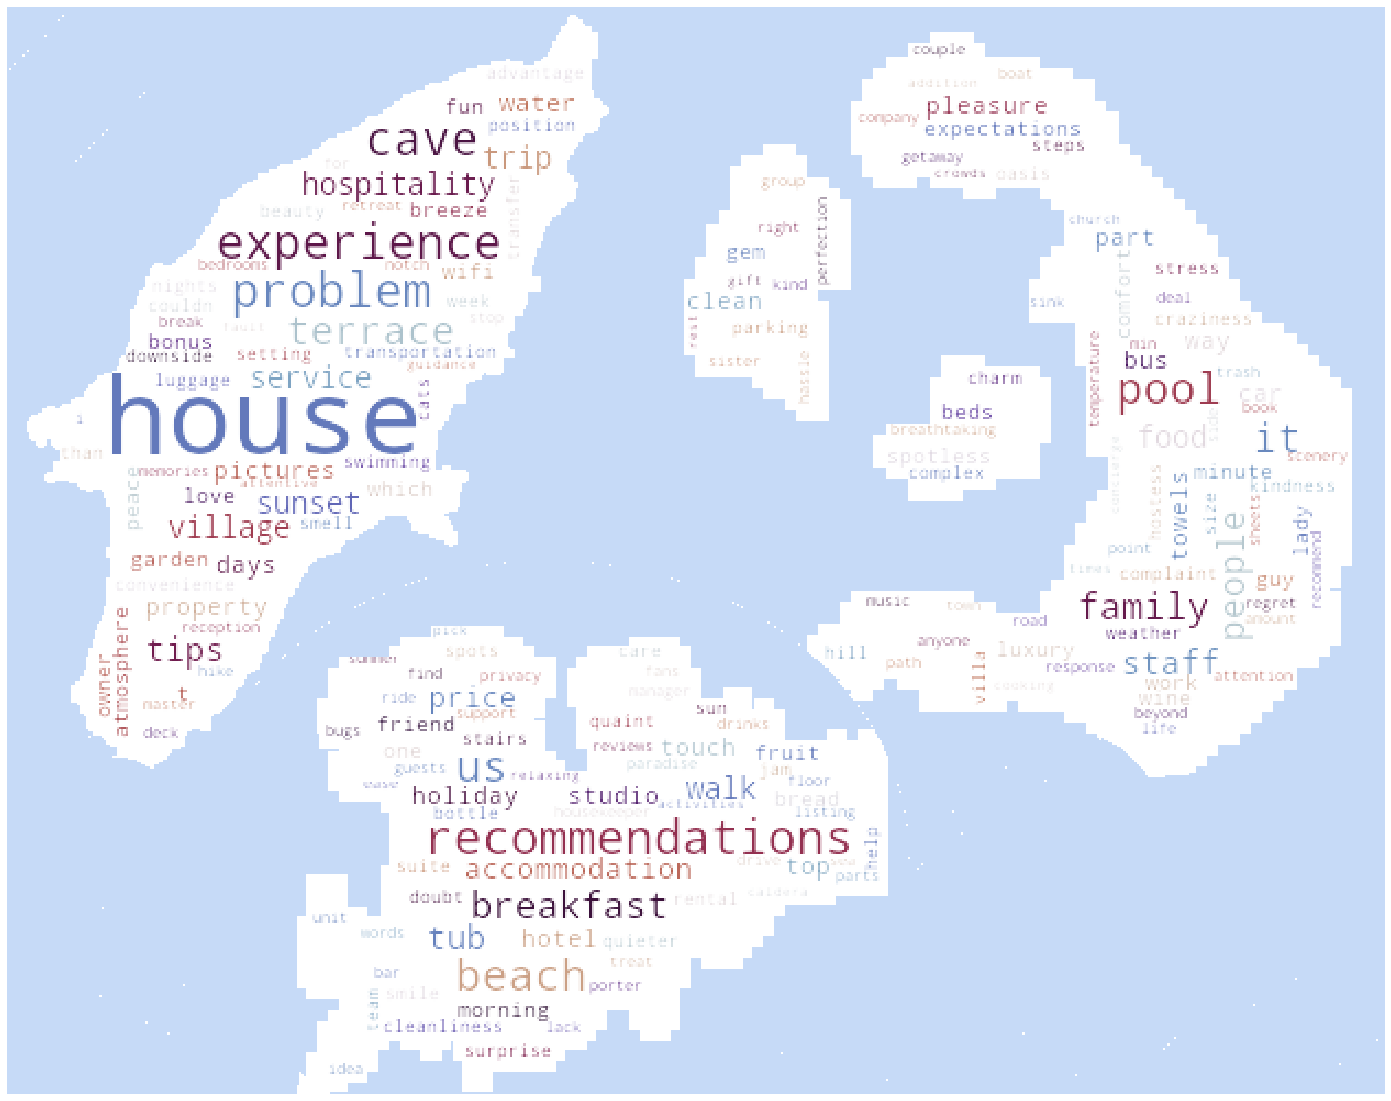

In [76]:
plt.figure(figsize=(30, 20))
plt.imshow(island_ocean)
plt.imshow(island_wc)
plt.axis("off")
plt.show()

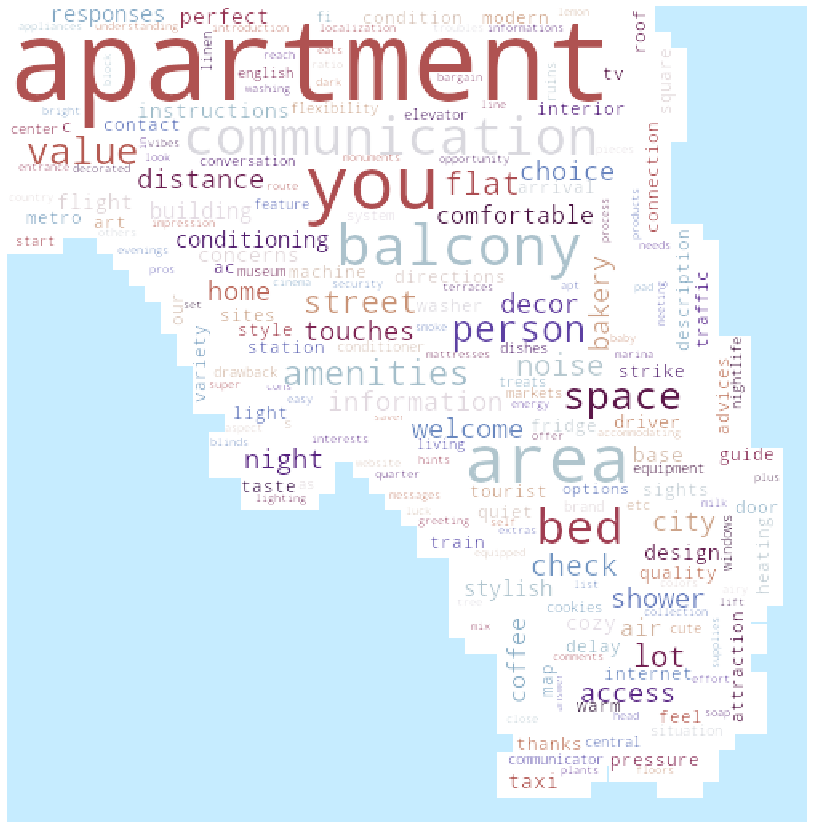

In [67]:
plt.figure(figsize=(25, 15))
plt.imshow(city_ocean)
plt.imshow(city_wc)
plt.axis("off")
plt.show()